<img src='figures/iaeaheader.svg' style='width:100%'/>
<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
<em>E-learning course on <br / ><br / >
Advanced Neutron Imaging</em>
</p> 

# Quantifying capillary rise using neutron radiography
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2023

<img src='figures/by-nc-nd.svg' style='height:30px'/>

## Introduction
Neutron imaging is used for many porous media experiments due to the great capacity of detecting small amounts of water in the solid matrix. In this tutorial we will look into the concept of [capillary rise in a porous sample](https://en.wikipedia.org/wiki/Capillary_action). This is when the sample suck up water into the sample by means of the capillary forces. The process can easily be observed using a time series of neutron radiographs. In the simple case with homogeneous samples this could also be observed by looking at the sample, but more complicated and heterogeneous samples require imaging for the full understanding. 

In [Cramer et al. 2022](https://doi.org/10.1002/vzj2.20215) the concept of capillary rise was used to study the water repellency caused by micro plastics.


## Tutorial objectives

- Planning a real time imaging experiment.
    - Finding pixel size and exposure time.
- Detecting the position of a water front in a time series.
    - Performing a capillary rise experiment (video demonstrations).
    - Reduction

### Loading some needed packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !git clone https://github.com/ImagingELearning/QuantifyingNeutronImages.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/QuantifyingNeutronImages/tutorial/00_Common/data/"
    sys.path.append("/content/scripts/python")
else: 
    # Running locally on your computer
    sys.path.append("../00_Common")
    data_path = "../00_Common/data/"

import amglib.bb as bb

## Estimating the pore size using capillary rise and Washborn's equation
From [Wikipedia](https://en.wikipedia.org/wiki/Washburn%27s_equation):
>In physics, Washburn's equation describes capillary flow in a bundle of parallel cylindrical tubes; it is extended with some issues also to imbibition into porous materials. 
A liquid having a dynamic viscosity $\eta$ and surface tension 
$\gamma$ will penetrate a distance $L$ into the capillary whose pore radius is $r$ following the relationship:
>$$L={\sqrt {\frac {\gamma rt\cos(\phi )}{2\eta }}}$$
>Where $\phi$  is the contact angle between the penetrating liquid and the solid (tube wall).

<img src="figures/rising-damp.jpg" style="height:300px" />

In this experiment, we will observe a water front rising in a sand packing using a time-series of neutron radiographs. 

### Video - Sample preparation

<video controls src="movies/CapillaryRisePreparation.mp4" height="300px" type="video/mp4"></video>

[On youtube](https://youtu.be/psSRvRROmCo)

### Video - Experiment on the desk

<video controls src="movies/CapillaryRiseExperiment.mp4" height="300px" type="video/mp4"></video>

[On youtube](https://youtu.be/dZdu9-lYaNE)

### Image acquisition
Load data from the experiments. Here will load a series of images and their time stamps.

In [33]:
img       = tiff.imread(data_path+'timeseries/sample3_images.tif')
time      = np.genfromtxt(data_path+'timeseries/sample3_timestamps.csv', delimiter=',', skip_header = 0)
pixelSize = 0.088 # mm

### Data reduction
The data in this exercise doesn't have the reference images we used before (ob and dc). The reason is that the source unfortunately stopped before these images could be obtained. Missing this data is not devastating for the task at hand, but would be needed if we would like to quantify the amount of water behind the water front. 

One operation you can test is to divide all images in the series by the first image. This would increase the contrast of the front and remove any other structures in the images.

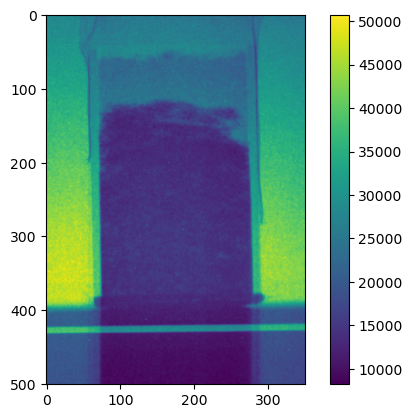

In [26]:
# Your code if you want to normalize the series
ref = img[0]
for i in range(img.shape[0]) :
    img[i]=img[i]/ref
    
plt.imshow(img[12])
plt.colorbar()

A further operation that could be considered is to remove possible outliers (spots) in the data. Here, it would be sufficient to apply a median filter.

In [34]:
# Apply a median filter
from skimage.filters import median
img = median(img, footprint=np.ones([1,5,5]))

### Extracting the front profile

The data you obtained from the experiment consists of series of radiographs. When these are stacked you will get a 3D volume with the axes x,y, and time. With this stucture of the data it is possible to extract y-t slices. Like in the example below.

<img src='figures/yt-slicing.svg' style="height:400px" />

The figure shows that depending on which direction you slice the data you'll see different details of the observed process. Looking at the mid panel you can clearly see how the water front is moving up. A single yt-slice may be too noisy for the following analysis. Therefore, it makes sense to select an interval which is averaged into the yt slice you see here. The left panel shows that the water surface not yet touch the bottom of the sand, while the panel to the right is in the middle of the process. 

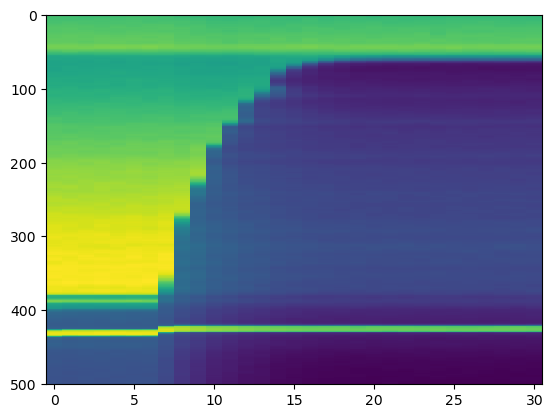

In [35]:
# Your code: get the yt slice

## compute the average of 50 vertical slices
yt=img[:,:,150:200].mean(axis=2).transpose()
plt.imshow(yt,aspect='auto', interpolation='None')

Once we have the yt-slice, we want to detect the water front in the image and measure where it is located. This segmentation and detection is done in several steps:
1. Find a threshold level. The value is found using a histogram e.g. ```_=plt.hist(data.ravel(),bins=100);```.  
__Note:__ The ravel operation is essential otherwise you'll get a histogram for each row in the image.

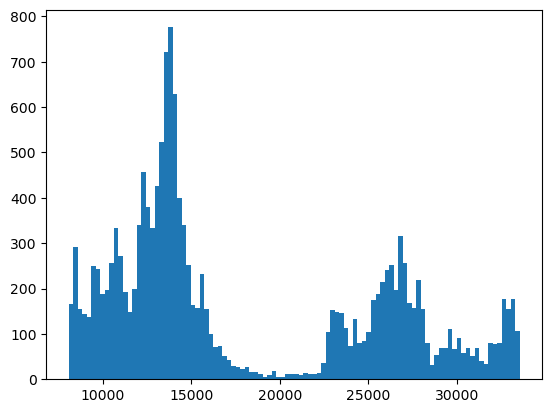

In [36]:
# Your code
_=plt.hist(yt.ravel(),bins=100)

2. Make a bi-level image when you found the threshold value

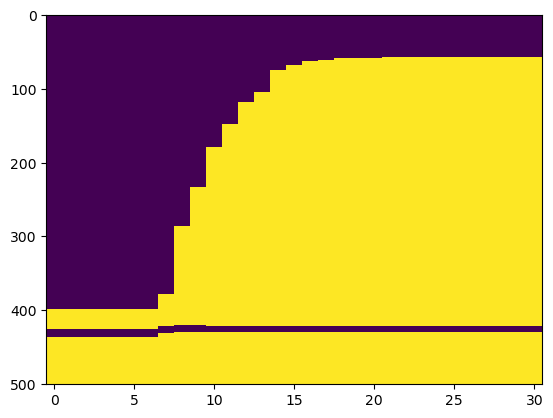

In [37]:
# your code
threshold = 20000 # adjust the threshold to obtain a bi level image showing the rising water front.
bi_yt = yt<threshold
plt.imshow(bi_yt,aspect='auto', interpolation='None')

3. Find the height position of the front as fnction of time. Here, the ```np.argmax(data,axis)``` is very helpful. Be careful to check that you subtract the correct bias and that the level is actuall rising.

In [48]:
# Your code
ypos=np.argmax(bi_yt,axis=0)
h=ypos[0]-ypos
h

array([  0,   1,   1,   1,   1,   1,   1,  21, 113, 166, 220, 251, 281,
       294, 324, 331, 336, 338, 340, 341, 341, 342, 342, 342, 342, 342,
       342, 342, 342, 342, 342])

4. Scale the height by the pixel size and plot the height as function of time. The time data was already loaded as ```time```.

In [49]:
# Your code
h = pixelSize * h 
h

array([ 0.   ,  0.088,  0.088,  0.088,  0.088,  0.088,  0.088,  1.848,
        9.944, 14.608, 19.36 , 22.088, 24.728, 25.872, 28.512, 29.128,
       29.568, 29.744, 29.92 , 30.008, 30.008, 30.096, 30.096, 30.096,
       30.096, 30.096, 30.096, 30.096, 30.096, 30.096, 30.096])

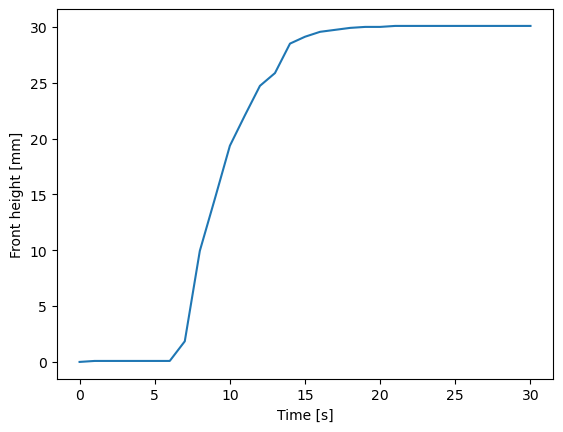

In [50]:
plt.plot(h)
plt.ylabel('Front height [mm]')
plt.xlabel('Time [s]');

### Fitting data to Washborn's equation

Here is a [tutorial](https://nbviewer.org/github/neutronimaging/coding-recipes/blob/main/python/CurveFitting.ipynb) how to fit a function to a data set.

The first step is to define a fitting function. This is best simplified to 
$$L=\sqrt{t\cdot{}k}$$

In [51]:
from scipy.optimize import curve_fit
# Your code
def washborn(t,k) :
    L = np.sqrt(k*t)
    
    return L

Now you are ready to fit your data. Make sure that you crop the time series to only match the active part. 

In [56]:
np.sqrt(h/1000)

array([0.        , 0.00938083, 0.00938083, 0.00938083, 0.00938083,
       0.00938083, 0.00938083, 0.04298837, 0.09971961, 0.12086356,
       0.13914022, 0.14862032, 0.15725139, 0.16084775, 0.16885497,
       0.17066927, 0.17195348, 0.17246449, 0.17297399, 0.17322817,
       0.17322817, 0.17348199, 0.17348199, 0.17348199, 0.17348199,
       0.17348199, 0.17348199, 0.17348199, 0.17348199, 0.17348199,
       0.17348199])

In [57]:
time[start:end]-time[start]

array([ 0.,  3.,  5.,  8., 10., 12., 15., 17.])

In [62]:
# Your code
start = 7
end   = 15
popt_w, pcov_w = curve_fit(washborn, time[start:end]-time[start], h[start:end])
popt_w = popt_w/1e6
print('fitted parameters',popt_w) # Scaling by 1e6 to convert from mm to m. The fitting failed when scaling was done on the input data.

fitted parameters [4.66127762e-05]


Plot the fitted data and check how well it fits the measured curve.

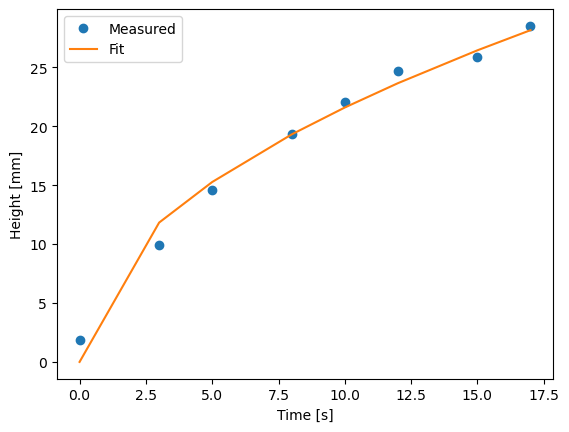

In [44]:
# Your code
plt.plot(time[start:end]-time[start],h[start:end],'o', label='Measured')
plt.plot(time[start:end]-time[start],washborn(time[start:end]-time[start],popt_w), label='Fit')
plt.xlabel('Time [s]')
plt.ylabel('Height [mm]')
plt.legend();

Now we have a fitted constant and can find the average pore size of the sand packing. To do this, we need some constants to complete Washborn's equation.

$$L={\sqrt {\frac {\gamma rt\cos(\phi )}{2\eta }}}$$

|Constant| Symbol | value |
|---|---|---|
| Surcafe tension |$\gamma$ |72 × 10$^{−3}$N/m |
| Dynamic viscosity |$\eta$ | 8.9 × 10$^{−4}$Ps |
|Wetting angle | $\phi$| 50$^{\circ}$ |

Rearrange the equation and calculate the pore radius.

The fitted coefficient $k$ is taken from Washborn's equation as
$$k=\frac{\gamma r \cos \phi}{2 \eta}$$

so the pore radius $r$ becomes

$$r=\frac{2\eta k}{\gamma \cos{\phi}}$$

In [66]:
# your code.
gamma = 72e-3
eta   = 8.9e-4
cosphi = np.cos(50*np.pi/180)

r = 2*eta*popt_w/(gamma*cosphi)

print('The pore radius is {0:0.3e} mm'.format(r[0]*1000))

The pore radius is 1.793e-03 mm


## Summary

In this tutorial, we learned how quantify information from neutron images.

1. We measured the attenuation coefficient of water and saw the impact of scattered neutrons. The attenuation coefficient is used to measure the amount of water in a sample based on varaiations in gray levels. It is therefore important to know this constant very precisely.

2. In the second experiment we tracked the position of the water front in a sample to measure the average pore radius in a sand packing.

In addition to learning more about these main objectives, we also learned how to use different python packages to solve the analysis tasks in a repeatable way and also how to present the results in plots and image displays.